# The OpenFE Showcase: Relative Binding Free Energy of TYK2
TODO: Rename if we add other protocols


# Intro

Welcome to the Open Free Energy toolkit!

The OpenFE toolkit provides open-source frameworks for calculating alchemical free energies. This notebook shows off the main things that you can do with OpenFE.

Here, we will introduce different components that users can choose from during setup of free energy calculations. OpenFE allow you to mix and match different components, such as:

* Atom mappers
* Scorers (for atom mappings)
* Ligand networks

This showcase currently focuses on relative binding free energy calculations and towards the end provides an introduction of other protocols in OpenFE, the MD protocol and absolute hydration free energy protocol.

If you are planning your own calculations, please also check out our tutorials that will walk you through setup, execution and analysis of different protocols:

* Add [links] for tutorial style notebooks

# Outline

0. Setup for Google Colab
1. Overview
3. Creating a transformation network
4. Running a Relative Ligand Binding Free Energy Calculation
5. Analysis

This is the current outline --> TODO: Adapt this to make for a nicer flow and add additional sections that are planned

## 0. Setup for Google Colab
TODO:  Clean this up and see if we can make it clean + hide it

If you are running this example in Google Colab, run the following cells to setup the environment. If you are running this notebook locally, skip down to `1. Overview`

In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2023/OpenFEforge-June-2023-Linux-x86_64.sh")

⏬ Downloading https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2023/OpenFEforge-June-2023-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:01:32
🔁 Restarting kernel...


In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-showcase
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/181L_mod_capped_protonated.pdb
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/Jnk1_ligands.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/benzene.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/ligands.sdf
Fetching https://raw.githubusercontent.com/OpenFreeEnergy/ExampleNotebooks/main/openmm_rbfe/inputs/styrene.sdf
✨🍰✨ Everything looks OK!


## 1. Overview

In this example we show how to set up a network of transformations using
the OpenFE toolkit for small chemical modifications of ligands binding to tyrosine kinase 2 (TYK2).

For convenience, a prepared (capped and protonated) PDB structure of the
TYK2 protein is provided under `inputs/tyk2_protein.pdb`. 

<img src="attachment:../openmm_rbfe/da4bf032-9a72-4e2d-9e6d-58e1ac5face9.png" width="300">

**TODO: Add image**

### Alchemical transformations of TYK2 ligands

Here we explore how OpenFE can be used to build a network for alchemical substitutions of the TYK2 ligands.

Ten pre-aligned compounds are available under
`inputs/tyk2_ligands.sdf`. These are shown in the cell below.

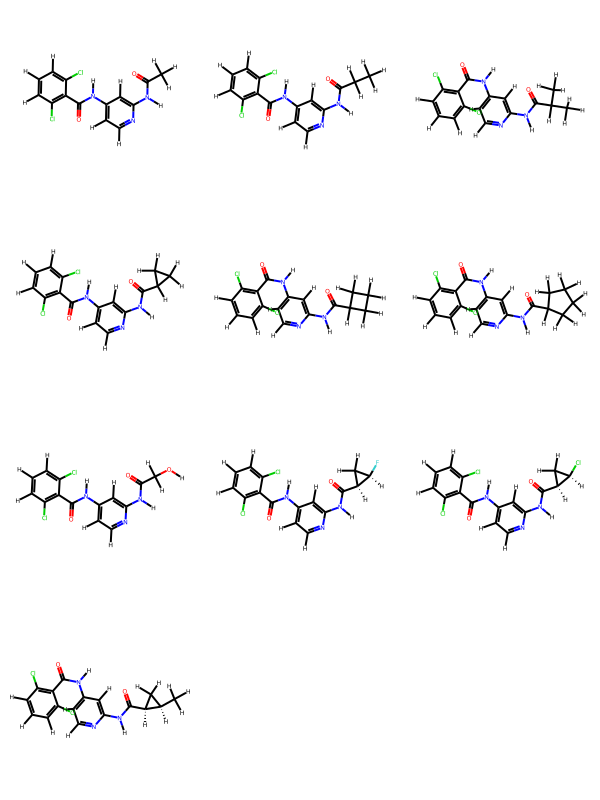

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol)

### The plan

Here is what we will achieve in this notebook and what software toolchains are
used along the way.

TODO Update this to include cinnabar IF this gets included 

| **Actions**                    | **Software**                                                |
|:------------------------------:|:-----------------------------------------------------------:|
| Create OpenFE Molecules        | OpenFE  RDKit                                            |
| Create Network                 | OpenFE  Lomap, Networkx                                  |
| Visualise Network              | OpenFE  NetworkX, RDKit, Matplotlib                      |
| Create ligand topologies       | OpenFE interface - OpenFF tk                             |
| Create hybrid OpenMM topology  | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Setup and run RBFE calculation | OpenFE interface - OpenMM + OpenMMTools                  |
| Analysis RBFE calculation      | OpenFE interface - PyMBAR + OpenMMTools                  |


A complete overview of the setup and simulation process starting from initial SDF and PDB files can be found [in this diagram](./../openmm_rbfe/assets/RBFE_workflow.drawio.pdf).

## 2. Creating a network of transformations

### Creating OpenFE SmallMoleculeComponents

In order to keep track of the various inputs being passed through the OpenFE
toolkit, OpenFE implements a set of Components which define the proteins,
small molecules and solvent components which a system may contain. Here we
use the [SmallMoleculeComponent](https://github.com/OpenFreeEnergy/gufe/blob/main/gufe/smallmoleculecomponent.py)
which takes in either [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)
or [OpenFF molecules](https://open-forcefield-toolkit.readthedocs.io/en/0.9.2/api/generated/openff.toolkit.topology.Molecule.html).

In the backend, OpenFE treats the RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example OpenEye's OEMol).

Here we demonstrate how to load the ligands from `inputs/tyk2_ligands.sdf` into a
list of OpenFE `SmallMoleculeComponent`s for further processing.

Load ligands using RDKit:

In [2]:
from openfe import SmallMoleculeComponent

# Load ligands using RDKit
ligands_sdf = Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

Load ligands using the OpenFF toolkit:

In [30]:
from openff.toolkit import Molecule
from openfe import SmallMoleculeComponent

# Load ligands using OpenFF toolkit
ligands_sdf = Molecule.from_file('inputs/tyk2_ligands.sdf')

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent.from_openff(sdf) for sdf in ligands_sdf]

OpenFE SmallMoleculeComponents have some useful built in attributes and methods.

For example the molecule's name (as defined by the SDF file) can be accessed

In [3]:
print("name: ", ligand_mols[0].name)

name:  lig_ejm_31


As previously stated `SmallMoleculeComponent`s also use the OpenFF backend to allow conversion between different object types. For example, it's possible to obtain an openff Molecule:

In [4]:
type(ligand_mols[0].to_openff())

openff.toolkit.topology.molecule.Molecule

### Ligand Atom Mapping

Our hybrid topology RBFE protocol, an atom mapping defines which atoms are mutated during the alchemicale transformation.
The user can choose between two different atom mappers:
1. `LomapAtomMapper`
    * based on the maximum common substructure (MCS)
2. `KartografAtomMapper`
    * based on the 3D geometries of the ligands

Whilst we use the defaults here, please note that the various supported arguments of
Lomap and Kartograf can be passed to the atom mapper.

In [5]:
from openfe.setup import LomapAtomMapper
mapper = LomapAtomMapper()
lomap_mapping = next(mapper.suggest_mappings(ligand_mols[0], ligand_mols[4]))

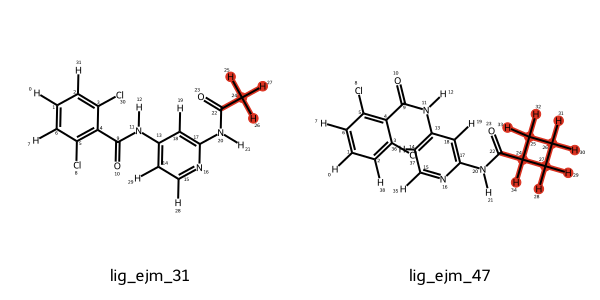

In [6]:
lomap_mapping

It is also possible to visualize the mapping in 3D:

In [32]:
# Visualize mapping in 3D
from openfe.utils import visualization_3D

visualization_3D.view_mapping_3d(lomap_mapping)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
from kartograf import KartografAtomMapper
# Build Kartograf Atom Mapper
mapper = KartografAtomMapper(atom_map_hydrogens=True)

# Get Mapping
kartograf_mapping = next(mapper.suggest_mappings(ligand_mols[0], ligand_mols[4]))

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms


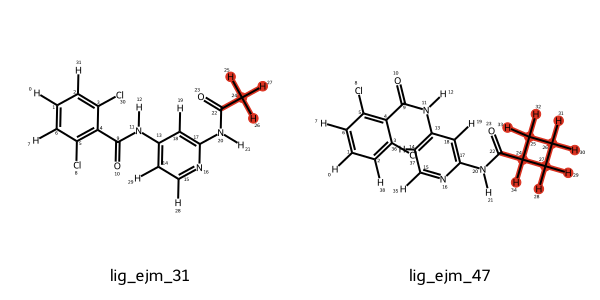

In [10]:
kartograf_mapping

### Creating a ligand network

A `LigandNetwork` is a set of `SmallMoleculeComponent`s that are connected by `AtomMapping`s of two small molecules. 

The user can choose between multiple different network topologies:
* Minimial spanning tree (MST)
* LOMAP network
* Radial (star) network
* Loading in networks from external software (FEP+ or Orion)
* Loading in a user defined network

In this section we will create and visualize the MST, LOMAP and radial networks for the TYK2 dataset.

In [11]:
# Create network from the two molecules
import openfe
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup.ligand_network_planning import generate_minimal_spanning_network
from openfe.setup.ligand_network_planning import generate_lomap_network
from openfe.setup import LomapAtomMapper

# Create an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),])

# Create a LOMAP network
lomap_network = generate_lomap_network(
    molecules=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),])

# Create a radial, choosing the first ligand as central ligand
radial_network = generate_radial_network(
    ligands=ligand_mols[1:],
    central_ligand=ligand_mols[0],
    mappers=[LomapAtomMapper(),])

 67%|######6   | 30/45 [00:01<00:00, 19.97it/s]

INFO:	Trying to remove edge 0-2 with similarity 0.818731
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 0-2
INFO:	Trying to remove edge 2-6 with similarity 0.860708
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 0-1 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 0-6 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 1-2 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 1-6 with similarity 0.951229
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 1-6
INFO:	Trying to remove edge 8-3 with similarity 0.904837
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 8-3
INFO:	Trying to remove edge 9-3 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 3-7 with similarity 0.904837
I

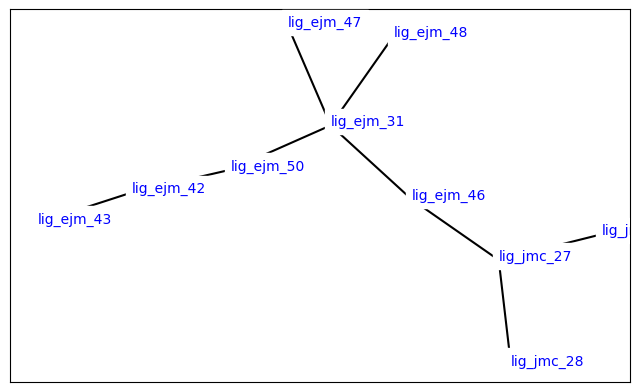

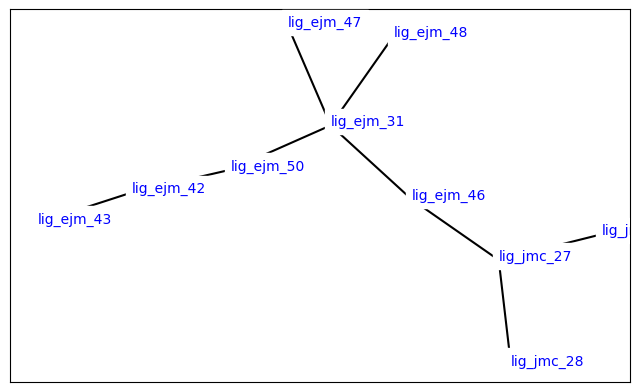

In [12]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(mst_network)

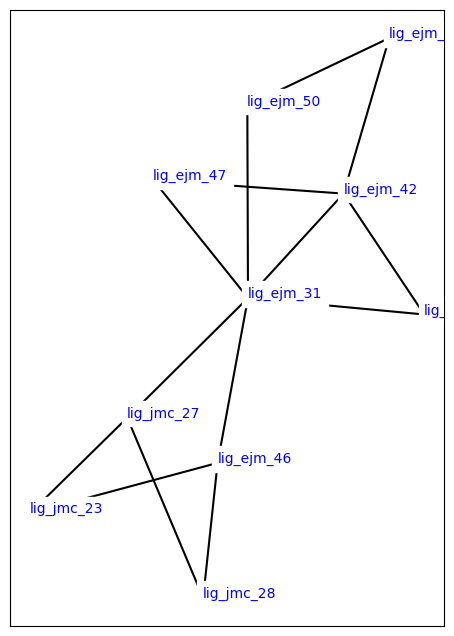

In [13]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(lomap_network)

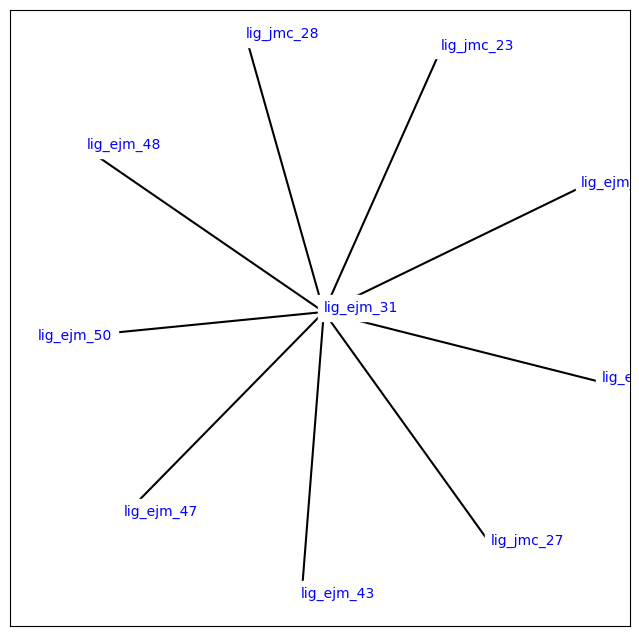

In [14]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(radial_network)

Edges along the network can be accessed to recover the invidual molecules involved in that given alchemical tranformation, and the atom mapping between the two ligands. 

**Note: as can be seen in the example below, transformations are defined within OpenFE as going from componentA to componentB**

In [20]:
mst_edges = [edge for edge in mst_network.edges]

# Pick an edge
edge = edges[1]

# Print the smiles of the molecules and the mapping
print("molecule A smiles: ", edge.componentA.smiles)
print("molecule B smiles: ", edge.componentB.smiles)
print("map between molecule A and B: ", edge.componentA_to_componentB)

molecule A smiles:  CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
molecule B smiles:  O=C(CO)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
map between molecule A and B:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 31: 29, 32: 30, 33: 31, 34: 32}


We can also visualise the atom mappings by invoking the individual OpenFE
AtomMapping objects directly.

Unique atoms between each mapping are shown in red, and atoms which are mapped
but undergo element changes are shown in blue. Bonds which either involve atoms that are unique or undergo element changes are highlighted in red.

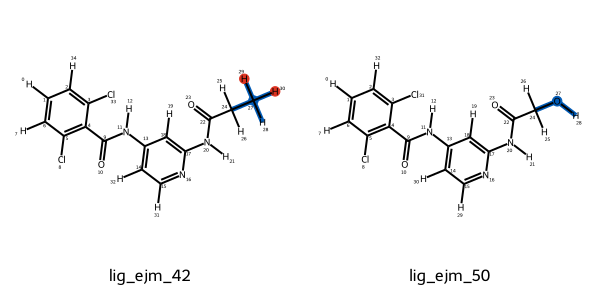

In [21]:
edge

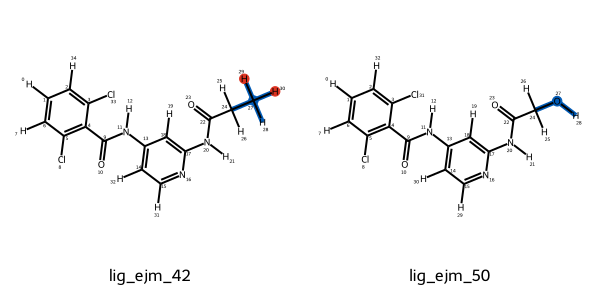

In [22]:
from IPython.display import Image

# mappings can also be saved to file if required
edge.draw_to_file('tyk2_edge.png')

# load it back for visualisation
Image("tyk2_edge.png")

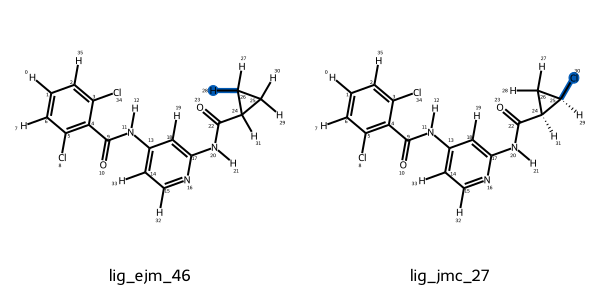

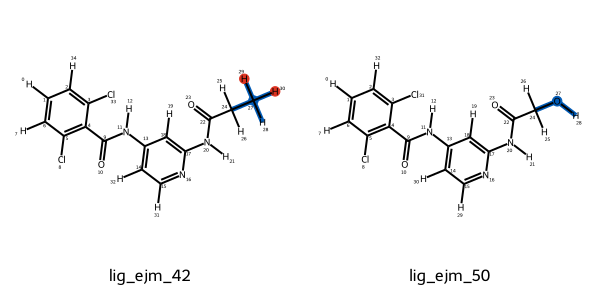

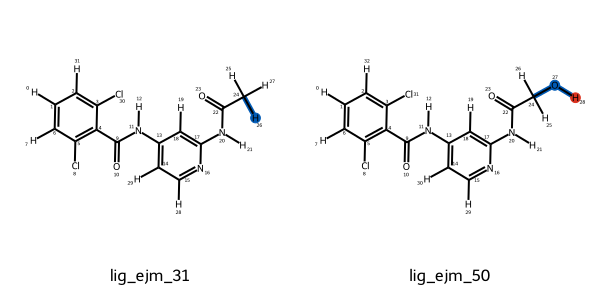

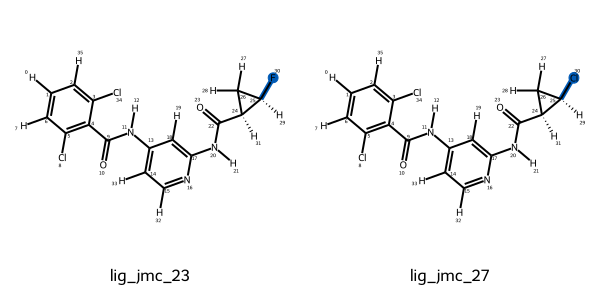

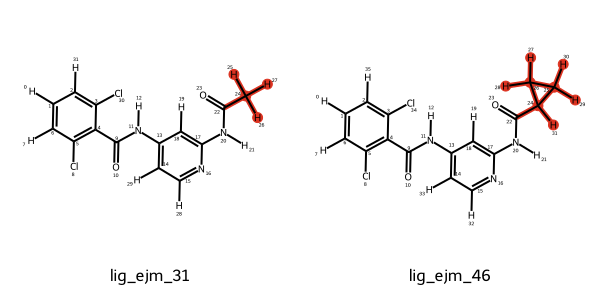

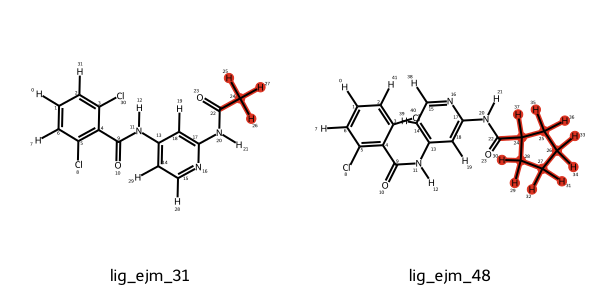

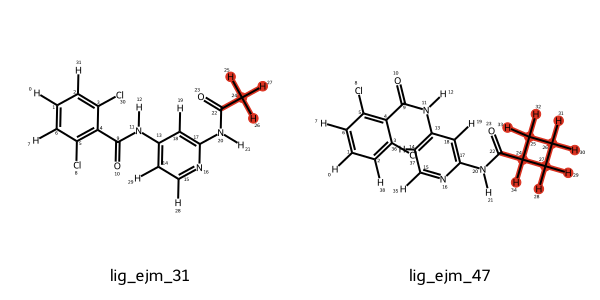

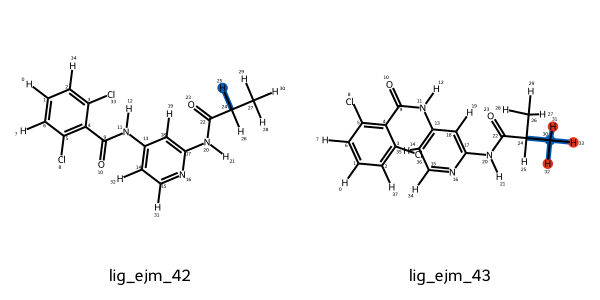

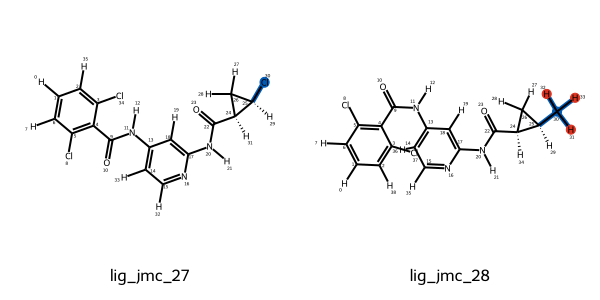

In [24]:
# Display all the atom mappings
for edge in mst_edges:
    display(edge)

### Storing the network

Created networks can easily be converted to (and also loaded from) as a GraphML representation.

This can allow users of OpenFE to store the network to disk for later use.

MMH: I think keeping that you can store the network is fine but we don't need more than this + the small code snnipit 

In [14]:
# Convert to graphml
with open("network_store.graphml", "w") as writer:
    writer.write(network.to_graphml())

### The OpenFE CLI

The OpenFE toolkit also has a command line interface which we plan to add several convenience methods to.

For now functionality is limited to atom mapping, but it will be expanded upon as the project grows.

TODO: How about we move the CLI to the end and say "you can do x, y, and z" with the CLI (Or just say "Oh we also have a CLI tool and it can do everything you just read about in this notebook) 

In [17]:
# Call help on the OpenFE CLI
!openfe --help

Usage: openfe [OPTIONS] COMMAND [ARGS]...

  This is the command line tool to provide easy access to functionality from
  the OpenFE Python library.

Options:
  --version   Show the version and exit.
  --log PATH  logging configuration file
  -h, --help  Show this message and exit.

Network Planning Commands:
  view-ligand-network  Visualize a ligand network
  plan-rhfe-network    Plan a relative hydration free energy network, saved as
                       JSON files for the quickrun command.
  plan-rbfe-network    Plan a relative binding free energy network, saved as
                       JSON files for the quickrun command.

Quickrun Executor Commands:
  gather    Gather result jsons for network of RFE results into a TSV file
  quickrun  Run a given transformation, saved as a JSON file

Miscellaneous Commands:
  test   Run the OpenFE test suite
  fetch  Fetch tutorial or other resource.


## 3. Running a Relative Ligand Binding Free Energy Calculation

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy cost of
transforming from one ligand to another.

To simulate this transformation we use the equilibrium RBFE protocol
implemented in OpenFE. This uses OpenMM to run a Perses-like relative
ligand binding free energy calculation using a single topology approach.

To achieve this simulation, the following steps need to happen:

1. Create OpenMM systems of both end states


2. Create a hybrid topology based on these defined endstates


3. Set an appropriate Lambda schedule


4. Set a MultiState reporter to write out appropriate coordinates and energies


5. Create an OpenMM sampler (in this case we will be using a replica exchange sampler)


6. Carry out the necessary simulation steps (minimization, equilibration, and production)


The `RelativeHybridTopologyProtocol` class in `openfe.protocols.openmm_rfe`
implements a means to achieve all the above with minimal intervention.

Here we work through its usage for the `lig_ejm_31` -> `lig_ejm_47` binding free energy
test case. As this involves both a relative binding free energy in solvent
and complex phases, the `RelativeHybridTopologyProtocol` Protocol will
be used to build two separate `ProtocolDAG` (directed-acyclic-graph) classes, one for each phase.
These `DAG`s (which contain the necessary individual simulations), are then executed to yield
the desired free energy results.

**Note: the underlying components used for the creation of OpenMM hybrid
topologies and samplers is still in flux, originating mostly from Perses.
Please consider these to be in beta.**

### Defining the ChemicalSystems

`ChemicalSystems` are OpenFE containers which define the various components
which exist in a system of interest. You can consider these to be the nodes
along an alchemical network which are connected by edges which carry out
calculations along Alchemical states to get free energies.

`ChemicalSystems` take in three different things:

1. A dictionary of the chemical components (e.g. `SmallMoleculeComponent`,
   `ProteinComponent`, `SolventComponent`) defining the system.


2. Box vectors (optional), defining the shape and size of the unit cell of the
   system.


3. An identifier name (optional), for the `ChemicalSystem`. This is used as part
   of the hash identifier of the `ChemicalSystem`, and can help distinguish between
   otherwise comparable systems.

In the case of a relative ligand binding free energy calculation for `lig_ejm_31` -> `lig_ejm_47`,
four `ChemicalSystems` must be defined:

1. `lig_ejm_31` in complex with TYK2 in a box of water


2. `lig_ejm_47` in complex with TYK2 in a box of water


3. `lig_ejm_31` in a box of water


4. `lig_ejm_47` in a box of water


Here we will be passing the previously defined `SmallMoleculeComponents` for `lig_ejm_31`
and `lig_ejm_47`. We will also pass a `ProteinComponent` generated from the PDB file
present under `inputs/tyk2_protein.pdb`. Finally, instead of passing
in a specific box of water, we will define a `SolventComponent` which will contain
the necessary information for OpenMM's `Modeller` class to add water and 0.15 M NaCl
around the solute when creating the OpenMM simulation objects.

In [20]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdb_file('inputs/tyk2_protein.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

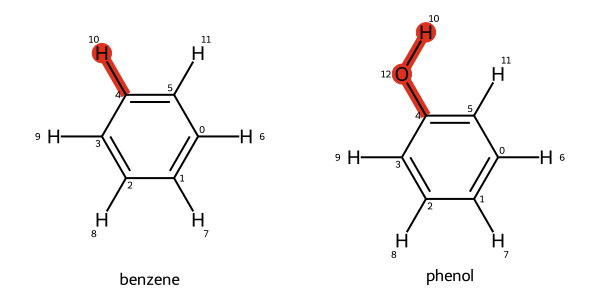

In [21]:
# Extract the relevant edge for the lig_ejm_31 -> lig_ejm_47 transform in the radial graph
ejm_31_to_ejm_47 = [edge for edge in network.edges if edge.componentB.name == "lig_ejm_47"][0]

ejm_31_to_ejm_47

In [22]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

ejm_31_complex = ChemicalSystem({'ligand': ejm_31_to_ejm_47.componentA,
                                  'solvent': solvent,
                                  'protein': protein,})
ejm_31_solvent = ChemicalSystem({'ligand': ejm_31_to_ejm_47.componentA,
                                  'solvent': solvent,})

ejm_47_complex = ChemicalSystem({'ligand': ejm_31_to_ejm_47.componentB,
                                 'solvent': solvent,
                                 'protein': protein,})
ejm_47_solvent = ChemicalSystem({'ligand': ejm_31_to_ejm_47.componentB,
                                 'solvent': solvent,})

### Defining the RBFE simulation settings

TODO: replace this with "we provide reasonable defaults and they are easy to modify"

There are various different parameters which can be set to determine
how the RBFE simulation will take place. To allow for maximum user flexibility, these are defined as a series of settings objects which control the following::

1. `protocol_repeats`: The number of completely independent repeats of the entire sampling process.

2. `simulation_settings`: Parameters controling the simulation plan and the alchemical sampler, including the number of minimization steps, lengths of equilibration and production runs, the sampler method (e.g. Hamiltonian replica exchange, `repex`), and the time interval at which to perform an analysis of the free energies.

3. `output_settings`: Simulation output control settings, including the frequency to write a checkpoint file, the selection string for which part of the system to write coordinates for, and the paths to the trajectory and output structure storage files.

4. `alchemical_settings`: Parameters controlling the creation of the hybrid topology system. This includes various parameters ranging from softcore parameters, through to whether or not to apply an explicit charge correction for systems with net charge changes.

5. `engine_settings`: Parameters determining how the OpenMM engine will execute the simulation. This controls the compute platform which will be used to carry out the simulation.

6. `integrator_settings`: Parameters controlling the `LangevinSplittingDynamicsMove` integrator used for simulation.

7. `lambda_settings`: Lambda protocol settings, including number of lambda windows and lambda functions.

8. `forcefield_settings`: Parameters to set up the force field with OpenMM Force Fields, including the general forcefields, the small molecule forcefield, the nonbonded method, and the nonbonded cutoff.

9. `thermo_settings`: Settings for thermodynamic parameters, such as the temperature and the pressure of the system.

10. `solvation_settings`: Settings for solvating the system, including the solvent model and the solvent padding.

11. `partial_charge_settings`: Settings for assigning partial charges to small molecules, including the partial charge method (e.g. `am1bcc`) and the openff toolkit backend (e.g. `ambertools` or `openeye`).

In [1]:
# Show importing default and change 1 or 2 settings

The `RelativeHybridTopologyProtocol` class can directly populate the above set of default
settings through its `default_settings` method.

In [15]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from openff.units import unit

# Create the default settings
rbfe_settings = RelativeHybridTopologyProtocol.default_settings()


# Parameters can be overriden after creation
# In this case, we'll reduce the equilibration length to 0.01 * nanosecond
# and the production to 0.05 * nanosecond in order to reduce the costs of
# running this notebook (in practice values of 2 and 5 nanoseconds
# respectively would be most appropriate)

rbfe_settings.simulation_settings.equilibration_length = 10 * unit.picosecond
rbfe_settings.simulation_settings.production_length = 50 * unit.picosecond

rbfe_settings.simulation_settings

{'early_termination_target_error': <Quantity(0.0, 'kilocalorie_per_mole')>,
 'equilibration_length': <Quantity(0.01, 'nanosecond')>,
 'minimization_steps': 5000,
 'n_replicas': 11,
 'production_length': <Quantity(0.05, 'nanosecond')>,
 'real_time_analysis_interval': <Quantity(250, 'picosecond')>,
 'real_time_analysis_minimum_time': <Quantity(500, 'picosecond')>,
 'sampler_method': 'repex',
 'sams_flatness_criteria': 'logZ-flatness',
 'sams_gamma0': 1.0,
 'time_per_iteration': <Quantity(1, 'picosecond')>}


### Creating the RelativeLigandTransform Protocol

With the Settings inspected and adjusted, we can provide these to the Protocol.
This Protocol defines the procedure to estimate a free energy difference between two chemical systems,
with the details of the two end states yet to be defined.

In [31]:
# Create RBFE Protocol class
rbfe_transform = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

### Simulating the RelativeLigandTransforms

Individual Units can then be executed by calling the `.execute()` method.

In the first instance we do a dry-run (which does everything but
starting the simulation) to make sure that the
hybrid openmm system can be constructed without any issues.
Note: A successful call to `.run()` will return an empty Dictionary.

In [ ]:
# complex dry-run
complex_unit = list(complex_dag.protocol_units)[0]

complex_unit.run(dry=True, verbose=True)

In [ ]:
# solvent dry-run
solvent_unit = list(solvent_dag.protocol_units)[0]

solvent_unit.run(dry=True, verbose=True)

### Executing the simulations.

TODO: explain here there are 4 ways to run sims, quick run, exorcist, alchemiscale, python API

## 4. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free
energies for both phases.

This can be achieved by passing the results of executing the DAGs calling the `gather()` methods of `RelativeLigandTransform`.
This takes a **list** of completed DAG results, catering for when simulations have been extended.

TODO: add cinnabar

In [39]:
# Get the complex and solvent results
complex_results = rbfe_transform.gather([complex_dag_results])
solvent_results = rbfe_transform.gather([solvent_dag_results])

print(f"Complex dG: {complex_results.get_estimate()}, err {complex_results.get_uncertainty()}")
print(f"Solvent dG: {solvent_results.get_estimate()}, err {solvent_results.get_uncertainty()}")

Complex dG: 3.8428725693840384 kilocalorie / mole, err 0.21918456914295942 kilocalorie / mole
Solvent dG: 1.206767244454323 kilocalorie / mole, err 0.32073333466272824 kilocalorie / mole
